# VAE for Fraud Detection

* Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

## Data Processing
* Convert time to real value
* std.scaler on `Time` and `Amount`

In [2]:
df = pd.read_csv(".\data\creditcard.csv")
df.loc[:,"Time"] = df["Time"].apply(lambda x : x / 3600 % 24)
df.loc[:,'Amount'] = np.log(df['Amount']+1)

df_scaled = df
df_scaled['Time'] = StandardScaler().fit_transform(df_scaled['Time'].values.reshape(-1, 1))
df_scaled['Amount'] = StandardScaler().fit_transform(df_scaled['Amount'].values.reshape(-1, 1))

df_scaled_normal = df_scaled[df_scaled.Class == 0]
df_scaled_fraud = df_scaled[df_scaled.Class == 1]

In [3]:
print('percent of fraud transaction data %.2f%%' %(df_scaled_fraud.shape[0]/df.shape[0]*100))

percent of fraud transaction data 0.17%


In [4]:
df_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.486373,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.124303,0
1,-2.486373,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.114639,0
2,-2.486326,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.682368,0
3,-2.486326,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.009339,0
4,-2.486278,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670241,0


In [5]:
train_normal, test_normal = train_test_split(df_scaled_normal, test_size=0.2)
train_normal = train_normal.drop(['Class'], axis=1) #drop the class column
test_normal = test_normal.drop(['Class'], axis=1) #drop the class column
test_fraud = df_scaled_fraud.drop(['Class'], axis=1)

train_normal = train_normal.values #transform to ndarray
test_normal = test_normal.values
test_fraud = test_fraud.values

## VAE Model
* Assume input data follows normal distribution and each features are independent.
* Output of decoder is a vector of reconstructed mean  and a vector of reconstructed log. variance

In [6]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_size, h_dim, z_dim):
        super().__init__()                    # intialize nn.Module, this works
        self.fc_e1 = nn.Linear(input_size, h_dim)
        self.fc_e2a = nn.Linear(h_dim, z_dim) # latent mean vector
        self.fc_e2b = nn.Linear(h_dim, z_dim) # latent log variance vector
        
        self.fc_d1 = nn.Linear(z_dim, h_dim)         # for first layer of decoder
        self.fc_d2a = nn.Linear(h_dim, input_size)   # second layer of decoder, reconstructed mean vector
        self.fc_d2b = nn.Linear(h_dim, input_size)   # second layer of decoder, reconstructed log.var vector
        
    # Encoding
    def encode(self, x):
        h = F.relu(self.fc_e1(x))             # could be tanh
        return self.fc_e2a(h), self.fc_e2b(h) # one for mean and one for log_variance
    
    # Reparameterizing trick, Generate Random Latent Vector
    def reparameterize(self, mu, log_var):
        std_dev = torch.exp(log_var/2)  # convert log_variance to std_dev
        eps = torch.randn_like(std_dev) # sampling from N(0,1)
        return mu + eps * std_dev
        
    # Decoding
    def decode(self, z):
        """
        suppose data follows a multi-variate normal distribution,
        decoder reconstruct the mean and log.variance
        """
        h = F.relu(self.fc_d1(z))
        mu_reconst = self.fc_d2a(h)
        log_var_reconst = self.fc_d2b(h)
        # could reconstruct a sample from N(mu,var) by utilize reparameterize method
        # here we don't use it
#         x_reconst = self.reparameterize(mu_reconst, log_var_reconst)
        return mu_reconst, log_var_reconst
    
    # foward propagation
    def forward(self, x):
        mu_latent, log_var_latent = self.encode(x)   #notice the output of encoder is mean and log_variance
        z = self.reparameterize(mu_latent, log_var_latent)
        mu_reconst, log_var_reconst = self.decode(z)
        return mu_latent, log_var_latent, mu_reconst, log_var_reconst
    
    

## Training
* Define reconstruction loss as negative loglikelihood     
  $$L(\tilde{\mathbf{x}}) = \ln (|\mathbf{\Sigma}_{\theta^*}|)+(\tilde{\mathbf{x}}-\boldsymbol{\mu}_{\theta^*})^{\top} \mathbf{\Sigma}_{\theta^*}^{-1}(\tilde{\mathbf{x}}-\boldsymbol{\mu}_{\theta^*})$$
* Ref. for reconstruction loss
* https://discuss.pytorch.org/t/multivariate-gaussian-variational-autoencoder-the-decoder-part/58235

In [7]:
def calculate_reconst_loss(x, mu_reconst, log_var_reconst):
    # neg log likelihood of x under normal
    reconst_loss = 0.5 * torch.sum(30 * np.log(2 * np.pi) + log_var_reconst + (x - mu_reconst)**2 / torch.exp(log_var_reconst))
    return reconst_loss

In [8]:
# ======== TRAINING DATA =============
train_tensor = torch.from_numpy(train_normal)
print("Size of Training Data:", train_normal.shape)


# ======== Hyper-parameters ========
input_size = train_normal.shape[1]  # here it's 30
h_dim = 10   # dimension of first layer
z_dim = 5    # will be 8, second layer, dim of latent vector z

num_epochs = 50
learning_rate = 1e-3

batch_size = 256
data_loader = torch.utils.data.DataLoader(dataset=train_tensor.float(),
                                          batch_size=batch_size, 
                                          shuffle=True)

# Create Instance for VAE
model = VAE(input_size = input_size, h_dim=h_dim, z_dim=z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ELBO_all, loglikelihood_all, KL_div_all  = [], [], []



for epoch in range(num_epochs):
    for i, x in enumerate(data_loader):
        
        # forward propagation
        mu_latent, log_var_latent, mu_reconst, log_var_reconst = model(x)
        
        # ================= COMPUTING LOSS & BACK-PROP ======================
        
        # using neg. log likelihood of x under normal
        reconst_loss = calculate_reconst_loss(x, mu_reconst, log_var_reconst) / batch_size
        # compute KL divergence
        kl_div = - 0.5 * torch.sum(1 + log_var_latent - mu_latent.pow(2) - log_var_latent.exp()) / batch_size
        
        # Back propagation, want to minimize loss
        # Notice -- 
        # ELBO = loglikelihood - KL_div, we want to maximize ELBO
        # maximize ELBO <==> minimize (ReconstructionLoss + KL_div)
        loss = (reconst_loss + kl_div)   # type(loss) = torch.Tensor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ================== SHOW TRAINING PROGRESS ==========================
        ELBO_all.append(-loss.item() if -loss.item() < -810 else -810)
        loglikelihood_all.append(-reconst_loss.item() if -reconst_loss.item() < -810 else -810)
        KL_div_all.append(kl_div.item())
        if (i%100)==0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.2f}, KL Div: {:.2f}, ELBO: {:.2f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item(), -loss.item()))

Size of Training Data: (227452, 30)
Epoch[1/50], Step [1/889], Reconst Loss: 843.62, KL Div: 0.26, ELBO: -843.88
Epoch[1/50], Step [101/889], Reconst Loss: 841.19, KL Div: 0.16, ELBO: -841.35
Epoch[1/50], Step [201/889], Reconst Loss: 840.06, KL Div: 0.15, ELBO: -840.21
Epoch[1/50], Step [301/889], Reconst Loss: 841.50, KL Div: 0.22, ELBO: -841.72
Epoch[1/50], Step [401/889], Reconst Loss: 842.18, KL Div: 0.38, ELBO: -842.56
Epoch[1/50], Step [501/889], Reconst Loss: 837.05, KL Div: 0.33, ELBO: -837.38
Epoch[1/50], Step [601/889], Reconst Loss: 836.25, KL Div: 0.83, ELBO: -837.07
Epoch[1/50], Step [701/889], Reconst Loss: 832.93, KL Div: 1.22, ELBO: -834.15
Epoch[1/50], Step [801/889], Reconst Loss: 832.01, KL Div: 1.33, ELBO: -833.35
Epoch[2/50], Step [1/889], Reconst Loss: 832.85, KL Div: 2.02, ELBO: -834.87
Epoch[2/50], Step [101/889], Reconst Loss: 831.99, KL Div: 1.70, ELBO: -833.69
Epoch[2/50], Step [201/889], Reconst Loss: 829.48, KL Div: 2.01, ELBO: -831.49
Epoch[2/50], Step [3

* Plot training curves

In [9]:
def plot(data_y1,data_y2=None,data_x1=None,data_x2=None,x_label=None,y_label=None,title=None,
        xlimit=None,ylimit=None,figsize=(8,4)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    if data_x1 != None:
        ax1.plot(data_x1,data_y1)
    else:
        ax1.plot(data_y1)
    if data_y2 != None and data_x2!=None:
        ax1.plot(data_x2,data_y2)
    elif data_y2 != None:
        ax1.plot(data_y2)
    ax1.set_ylabel(y_label)
    ax1.set_xlabel(x_label)
    ax1.set_title(title)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.show()

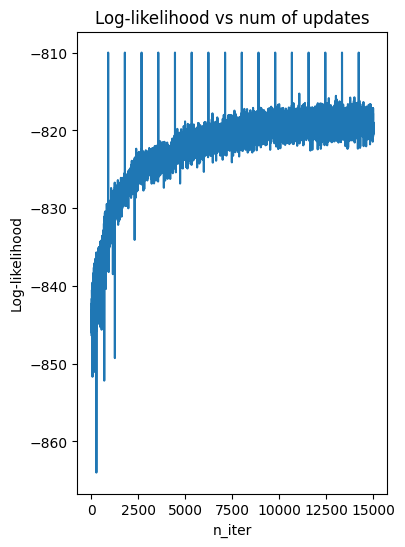

In [10]:
loglikelihood_all = np.array(loglikelihood_all)
plot(data_y1=loglikelihood_all[(loglikelihood_all>-870)&(loglikelihood_all<-790)][:15000],
     data_x1=None,x_label='n_iter',
     y_label='Log-likelihood',title='Log-likelihood vs num of updates',
     figsize = (4,6))

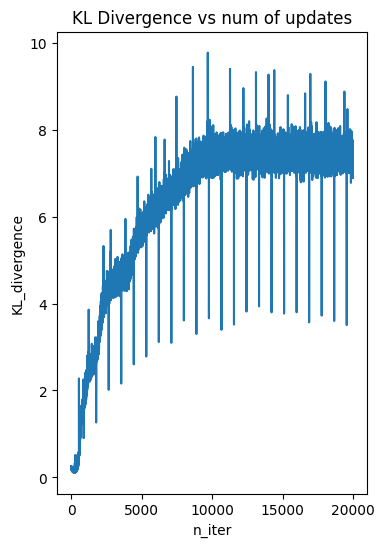

In [11]:
KL_div_all = np.array(KL_div_all)
plot(data_y1=KL_div_all[KL_div_all<1e5][:20000],
     data_x1=None,x_label='n_iter',
     y_label='KL_divergence',title='KL Divergence vs num of updates',
    figsize=(4,6))


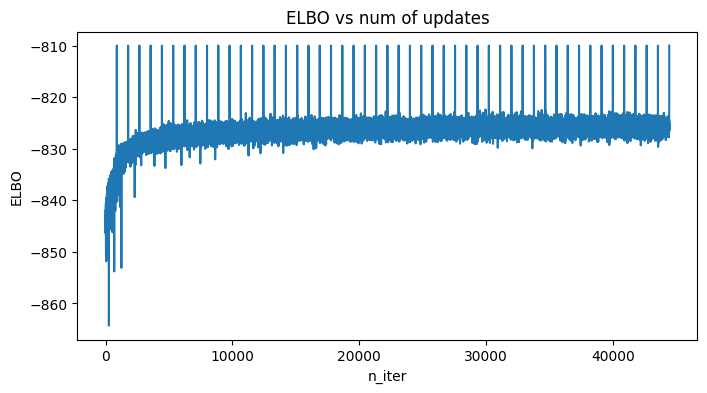

In [12]:
ELBO_all = np.array(ELBO_all)
plot(data_y1=ELBO_all[(ELBO_all>-880)],
     data_x1=None,x_label='n_iter',
     y_label='ELBO',title='ELBO vs num of updates')

## Prediction

In [13]:
def calculate_sample_reconst_loss(mu,log_var,sample):
    """
    mu: 1*n_features, vector
    var: 1*n_features, vector
    """
    loss = calculate_reconst_loss(sample, mu, log_var)

    return loss.item()

In [14]:
def getReconstLoss(data,n_sample=100):
    result = []
    for i in range(data.shape[0]):
        if (i%1000==0):
            print('[%d/%d] samples finished' %(i,data.shape[0]))
        train_scaled_tensor = torch.from_numpy(data[i])
        reconst_loss = 0
        sample = train_scaled_tensor.float()   # 
        with torch.no_grad():
            _, _, mu_reconst, log_var_reconst = model(sample)
            reconst_loss = calculate_sample_reconst_loss(mu_reconst, 
                                                         log_var_reconst,
                                                         sample) 
            result.append(reconst_loss)
    return np.array(result)
reconst_loss_normal = getReconstLoss(test_normal)
reconst_loss_fraud = getReconstLoss(test_fraud)

[0/56863] samples finished
[1000/56863] samples finished
[2000/56863] samples finished
[3000/56863] samples finished
[4000/56863] samples finished
[5000/56863] samples finished
[6000/56863] samples finished
[7000/56863] samples finished
[8000/56863] samples finished
[9000/56863] samples finished
[10000/56863] samples finished
[11000/56863] samples finished
[12000/56863] samples finished
[13000/56863] samples finished
[14000/56863] samples finished
[15000/56863] samples finished
[16000/56863] samples finished
[17000/56863] samples finished
[18000/56863] samples finished
[19000/56863] samples finished
[20000/56863] samples finished
[21000/56863] samples finished
[22000/56863] samples finished
[23000/56863] samples finished
[24000/56863] samples finished
[25000/56863] samples finished
[26000/56863] samples finished
[27000/56863] samples finished
[28000/56863] samples finished
[29000/56863] samples finished
[30000/56863] samples finished
[31000/56863] samples finished
[32000/56863] samples

## Evaluation

Text(0.5, 1.0, 'Distribution of Reconstruction Loss')

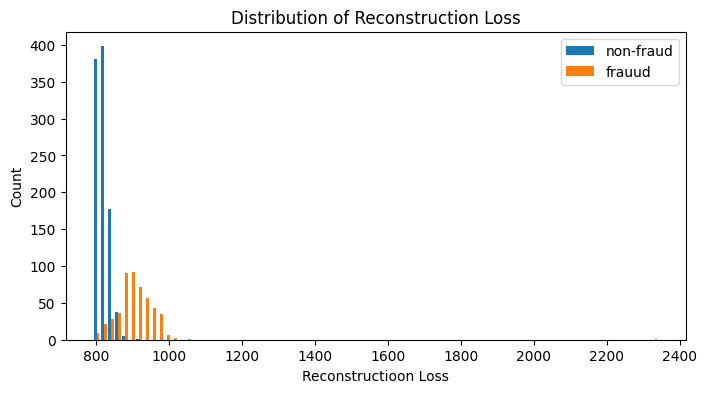

In [15]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,4))
plt.hist([reconst_loss_normal[7000:8000],
          reconst_loss_fraud],80,label=['non-fraud','frauud']);
plt.legend(loc='best')
plt.xlabel('Reconstructioon Loss')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Loss')

In [16]:
label_fraud = np.ones(shape=reconst_loss_fraud.shape)
label_normal = np.zeros(shape=reconst_loss_normal.shape)
label_all = np.concatenate((label_fraud , label_normal))
reconst_loss_all = np.concatenate((reconst_loss_fraud, reconst_loss_normal))

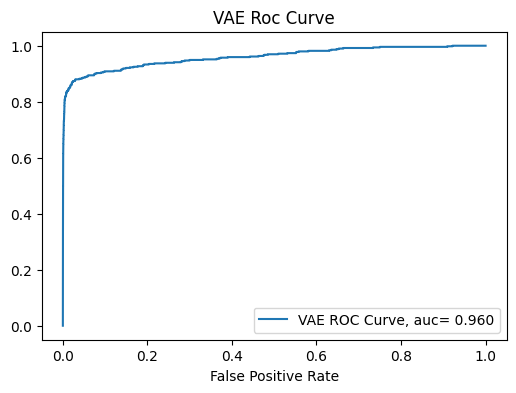

In [17]:
fpr_vae, tpr_vae, threshold = roc_curve(label_all, reconst_loss_all)
auc_vae = roc_auc_score(label_all, reconst_loss_all)

plt.figure(figsize=(6,4))
plt.plot(fpr_vae,tpr_vae,label="VAE ROC Curve, auc= %.3f"%(auc_vae))
plt.title('VAE Roc Curve')
# plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

In [18]:
idx_optimal = np.argmax(tpr_vae-fpr_vae) # optimal point on ROC curve
threshold_optimal = threshold[idx_optimal]
tpr_optimal, fpr_optimal = tpr_vae[idx_optimal], fpr_vae[idx_optimal]
print("Optimal Threshold of Neg. Log Likelihood is %.3f, with TPR= %.3f, FPR= %.3f" 
      %(threshold_optimal,tpr_optimal,fpr_optimal))

Optimal Threshold of Neg. Log Likelihood is 851.246, with TPR= 0.880, FPR= 0.030


In [19]:
def calculate_fnr(y_true,y_pred):
    confMat = confusion_matrix(y_true,y_pred)
    FN = confMat[1,0]
    TP = confMat[1,1]
    FNR = FN/(TP+FN)
    return FNR

In [20]:
def vae_prediction(nll,thres):
    result = []
    for item in nll:
        if item>=thres:
            result.append(1)
        else:
            result.append(0)
    return np.array(result)
y_pred_vae = vae_prediction(reconst_loss_all, threshold_optimal)
FNR = calculate_fnr(label_all,y_pred_vae)
print("FNR of VAE is %.2f%%" %(FNR*100))

FNR of VAE is 11.99%


## Comparison with Random Forest and Logistic Reg.

### Prepare data for supervised model

In [21]:
df_scaled_normal = df_scaled[df_scaled.Class == 0]
df_scaled_fraud = df_scaled[df_scaled.Class == 1]
train_normal_tree, test_normal_tree = train_test_split(df_scaled_normal, test_size=0.8) # reduce imbalance
train_fraud_tree,test_fraud_tree = train_test_split(df_scaled_fraud, test_size=0.2)
train_normal_tree = train_normal_tree.drop(['Class'], axis=1)  # drop the class column
train_fraud_tree = train_fraud_tree.drop(['Class'], axis=1)  # drop the class column
test_normal_tree = test_normal_tree.drop(['Class'], axis=1)    # drop the class column
test_fraud_tree = test_fraud_tree.drop(['Class'],axis=1)

X_train = np.concatenate((train_normal_tree,train_fraud_tree))
y_normal = np.zeros(shape=train_normal_tree.shape[0])
y_fraud = np.ones(shape=train_fraud_tree.shape[0])
y_train = np.concatenate((y_normal,y_fraud))


X_test = np.concatenate((test_normal_tree,test_fraud_tree))
y_normal = np.zeros(shape=test_normal_tree.shape[0])
y_fraud = np.ones(shape=test_fraud_tree.shape[0])
y_test = np.concatenate((y_normal,y_fraud))


### Random Forest

In [22]:
clf = RandomForestClassifier(n_estimators=100,max_depth=1,n_jobs=-1)
clf.fit(X_train[-2000:],y_train[-2000:])
y_prob_rf = clf.predict_proba(X_test)[:,1]
y_pred_rf = (np.sign(y_prob_rf-0.5)+1)/2
y_pred_rf = y_pred_rf.astype(int)
print(confusion_matrix(y_test,y_pred_rf))

[[227392     60]
 [    19     80]]


In [23]:
fpr_rf, tpr_rf, threshold_roc = roc_curve(y_test, y_prob_rf)

idx_optimal = np.argmax(tpr_rf-fpr_rf) # optimal point on ROC curve
threshold_roc_optimal = threshold_roc[idx_optimal]
tpr_optimal, fpr_optimal = tpr_rf[idx_optimal], fpr_rf[idx_optimal]
print("Optimal threshold_roc of Prob. is %.2f"%(threshold_roc_optimal))

fnr_rf =  calculate_fnr(y_test,y_pred_rf)
print('True Pos. Rate for Random Forest: %.2f%%' % (tpr_optimal*100))
print('False Neg. Rate for Random Forest: %.2f%%' % (fnr_rf*100))
print('False Pos. Rate for Random Forest: %.2f%%' % (fpr_optimal*100))

Optimal threshold_roc of Prob. is 0.23
True Pos. Rate for Random Forest: 86.87%
False Neg. Rate for Random Forest: 19.19%
False Pos. Rate for Random Forest: 0.68%


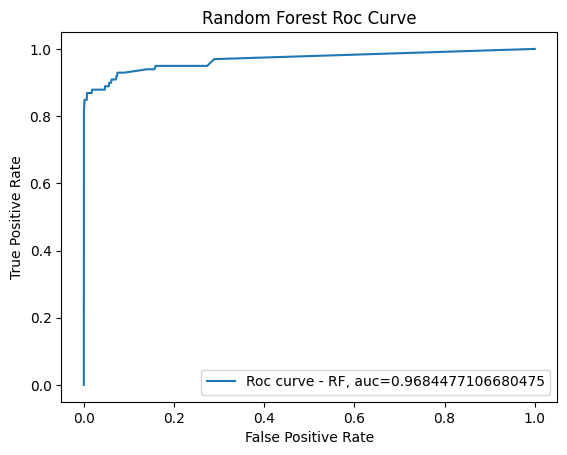

In [24]:
auc_rf = roc_auc_score(y_test, y_prob_rf)
plt.plot(fpr_rf,tpr_rf,label="Roc curve - RF, auc="+str(auc_rf))
plt.title('Random Forest Roc Curve')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
clf = LogisticRegression(random_state=0,C=1)
clf.fit(X_train[:],y_train[:])
y_prob_lr = clf.predict_proba(X_test)[:,1]
y_pred_lr = (np.sign(y_prob_lr-0.5)+1)/2
y_pred_lr = y_pred_lr.astype(int)
print(confusion_matrix(y_test,y_pred_lr))

[[227385     67]
 [    22     77]]


Optimal Threshold of Prob. is 0.00
True Pos. Rate for Logistic Regression: 95.96%
False Neg. Rate for Logistic Regression: 22.22%
False Pos. Rate for Logistic Regression: 5.69%


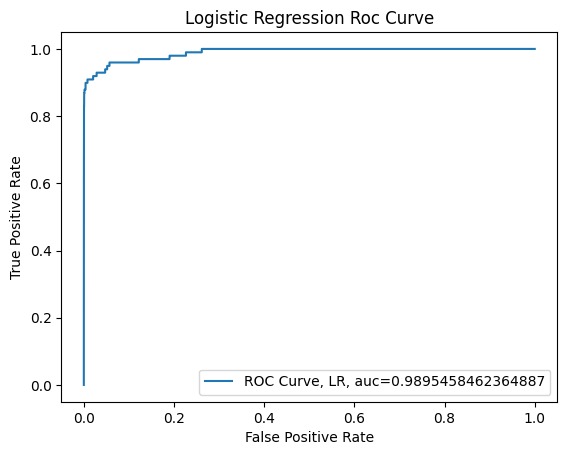

In [27]:
fpr_lr, tpr_lr, threshold = roc_curve(y_test, y_prob_lr)

idx_optimal = np.argmax(tpr_lr-fpr_lr) # optimal point on ROC curve
threshold_optimal = threshold[idx_optimal]
tpr_lr_optimal, fpr_lr_optimal = tpr_lr[idx_optimal], fpr_lr[idx_optimal]
print("Optimal Threshold of Prob. is %.2f"%(threshold_optimal))

fnr_lr =  calculate_fnr(y_test,y_pred_lr)
print('True Pos. Rate for Logistic Regression: %.2f%%' % (tpr_lr_optimal*100))
print('False Neg. Rate for Logistic Regression: %.2f%%' % (fnr_lr*100))
print('False Pos. Rate for Logistic Regression: %.2f%%' % (fpr_lr_optimal*100))

auc_lr = roc_auc_score(y_test, y_prob_lr)
plt.plot(fpr_lr,tpr_lr,label="ROC Curve, LR, auc="+str(auc_lr))
plt.title('Logistic Regression Roc Curve')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

### Plot ROC curves of three models

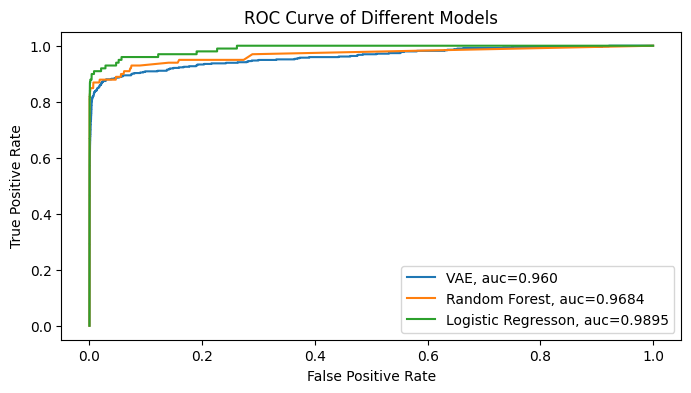

In [28]:

plt.figure(figsize=(8,4))
plt.plot(fpr_vae,tpr_vae,label="VAE, auc=%.3f"%(auc_vae))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, auc=%.4f"%(auc_rf)) # plotting t, a separately 
plt.plot(fpr_lr,tpr_lr,label="Logistic Regresson, auc=%.4f"%(auc_lr)) # plotting t, b separately 
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.title('ROC Curve of Different Models')
plt.show()